# Работа группы №4
Байбикова Анастасия, Злобина Надежда, Зубова Наталья,Королев Сергей, Уаман Татьяна, Фомина Юлия, Люляев Иван

### Вариант 2

Вы работаете аналитиком в Убере, по данному набору
проанализируйте вашу конкуренцию с компанией Лифт, посмотрите
кто делает больше поездок и когда, как работает ваше
ценообразование и ценообразование компании Лифт, какие у вас
поездки, а какие у них и так далее. Результатом должен стать ряд
гипотез по улучшению.  


In [578]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from time import*


In [579]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

## Загрузка данных
файл лежит в этой же папке

In [580]:
df = pd.read_csv('data/cab_rides.csv')

In [581]:
df.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL


#### Расшифровка колонок
**distance** - distance between source and destination  
**cab_type** - Uber or Lyft  
**time_stamp** - epoch time when data was queried in millisec   
**destination** - destination of the ride  
**source** - the starting point of the ride  
**price** - price estimate for the ride in USD  
**surge_multiplier** - the multiplier by which price was increased, default 1  
**id** - unique identifier  
**product_i** - uber/lyft identifier for cab-type  
**name** - visible type of the cab eg: Uber Pool, UberXL  

## Добавим признаки
### Категориальные признаки
#### Компания

In [582]:
df.cab_type.unique()

array(['Lyft', 'Uber'], dtype=object)

Нулевых значений нет, присвоим идентификаторы:  
  
**Uber** - 1  
**Lyft** - 0

In [583]:
df['cab_type_id'] =[1 if i == 'Uber' else 0 for i in df.cab_type]

#### Места посадок и высадок

In [584]:
place_list = list(set(list(df.source.unique()) +list(df.destination.unique())))
print('Всего мест {}:\n'.format(len(place_list)))
print(*place_list,  sep=',', end='.')

Всего мест 12:

North Station,Northeastern University,Beacon Hill,Back Bay,Theatre District,North End,Haymarket Square,South Station,Fenway,Boston University,Financial District,West End.

Всего 12 мест, дадим каждому из них идентификатор от 0 до 11.

In [585]:
place_df = pd.DataFrame(place_list, columns=['place'])
place_df['place_id']=place_df.index

##### Присвоим этим местам координаты

In [586]:
place_df.loc[0, 'latitude'] = 42.366280
place_df.loc[0, 'longtitude'] = -71.060912

place_df.loc[1, 'latitude'] = 42.340291
place_df.loc[1, 'longtitude'] = -71.088718

place_df.loc[2, 'latitude'] = 42.358869
place_df.loc[2, 'longtitude'] = -71.067680

place_df.loc[3, 'latitude'] = 42.349577
place_df.loc[3, 'longtitude'] = -71.079523

place_df.loc[4, 'latitude'] = 42.351883
place_df.loc[4, 'longtitude'] = -71.064252

place_df.loc[5, 'latitude'] = 42.365664
place_df.loc[5, 'longtitude'] = -71.054778

place_df.loc[6, 'latitude'] = 42.363789
place_df.loc[6, 'longtitude'] = -71.058442

place_df.loc[7, 'latitude'] = 42.352332
place_df.loc[7, 'longtitude'] = -71.055553

place_df.loc[8, 'latitude'] = 42.346468
place_df.loc[8, 'longtitude'] = -71.098775

place_df.loc[9, 'latitude'] = 42.350185
place_df.loc[9, 'longtitude'] = -71.105924

place_df.loc[10, 'latitude'] = 42.356122
place_df.loc[10, 'longtitude'] = -71.054911

place_df.loc[11, 'latitude'] = 42.363877
place_df.loc[11, 'longtitude'] = -71.067056

place_df

,place,place_id,latitude,longtitude
0,North Station,0,42.366280,-71.060912
1,Northeastern University,1,42.340291,-71.088718
2,Beacon Hill,2,42.358869,-71.067680
3,Back Bay,3,42.349577,-71.079523
4,Theatre District,4,42.351883,-71.064252
5,North End,5,42.365664,-71.054778
6,Haymarket Square,6,42.363789,-71.058442
7,South Station,7,42.352332,-71.055553
8,Fenway,8,42.346468,-71.098775
9,Boston University,9,42.350185,-71.105924


In [587]:
place_df.columns=['source', 'source_id', 'source_latitude', 'source_longtitude']
df=pd.merge(df,place_df, how='inner', on='source')

In [588]:
place_df.columns=['destination', 'destination_id', 'destination_latitude', 'destination_longtitude']
df=pd.merge(df,place_df, how='inner', on='destination')

In [589]:
place_df.columns=['source', 'source_id', 'source_latitude', 'source_longtitude']

In [590]:
place_df

,source,source_id,source_latitude,source_longtitude
0,North Station,0,42.366280,-71.060912
1,Northeastern University,1,42.340291,-71.088718
2,Beacon Hill,2,42.358869,-71.067680
3,Back Bay,3,42.349577,-71.079523
4,Theatre District,4,42.351883,-71.064252
5,North End,5,42.365664,-71.054778
6,Haymarket Square,6,42.363789,-71.058442
7,South Station,7,42.352332,-71.055553
8,Fenway,8,42.346468,-71.098775
9,Boston University,9,42.350185,-71.105924


In [591]:
df.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,cab_type_id,source_id,source_latitude,source_longtitude,destination_id,destination_latitude,destination_longtitude
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared,0,6,42.363789,-71.058442,0,42.36628,-71.060912
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux,0,6,42.363789,-71.058442,0,42.36628,-71.060912
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft,0,6,42.363789,-71.058442,0,42.36628,-71.060912
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL,0,6,42.363789,-71.058442,0,42.36628,-71.060912
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL,0,6,42.363789,-71.058442,0,42.36628,-71.060912


#### Маршруты

In [592]:
print('Всего маршрутов:',df.groupby(['source', 'destination']).count().shape[0])

Всего маршрутов: 72


In [593]:
route_df=pd.DataFrame([list(i) for i in list(df.groupby(['source', 'destination']).count().index)], columns=['source', 'destination'])
route_df['route_id'] = route_df.index
route_df['route_name']=route_df.source+'-'+route_df.destination
route_df.head()

,source,destination,route_id,route_name
0,Back Bay,Boston University,0,Back Bay-Boston University
1,Back Bay,Fenway,1,Back Bay-Fenway
2,Back Bay,Haymarket Square,2,Back Bay-Haymarket Square
3,Back Bay,North End,3,Back Bay-North End
4,Back Bay,Northeastern University,4,Back Bay-Northeastern University


In [594]:
df=pd.merge(df,route_df, how='inner', on=['source','destination'])

#### Тариф (тип поездки)

In [595]:
df.name.unique()

array(['Shared', 'Lux', 'Lyft', 'Lux Black XL', 'Lyft XL', 'Lux Black',
       'Black', 'WAV', 'Taxi', 'UberX', 'Black SUV', 'UberPool', 'UberXL'],
      dtype=object)

In [596]:
print('Всего тарифов:{}\nТарифы Убера {}  \nТарифы Лифта {}'.format(len(df.name.unique()),df[df.cab_type=='Uber'].name.unique(),df[df.cab_type=='Lyft'].name.unique()))

Всего тарифов:13
Тарифы Убера ['Black' 'WAV' 'Taxi' 'UberX' 'Black SUV' 'UberPool' 'UberXL']  
Тарифы Лифта ['Shared' 'Lux' 'Lyft' 'Lux Black XL' 'Lyft XL' 'Lux Black']


In [597]:
tariff_df = pd.DataFrame(df.name.unique(), columns=['name'])
tariff_df['tariff_id']=tariff_df.index
tariff_df

,name,tariff_id
0,Shared,0
1,Lux,1
2,Lyft,2
3,Lux Black XL,3
4,Lyft XL,4
5,Lux Black,5
6,Black,6
7,WAV,7
8,Taxi,8
9,UberX,9


Примечание: надо постараться выявить аналогии между тарифами двух компаний

Соответсвия тарифов по сути:
1. Lux Black XL = Black SUV - дорогие кроссоверы без таксишной расскраски
2. Lux Black = Black - дорогие седаны без раскраски
3. Lyft XL = Uber XL - минивэн
4. Shared = UberPool - сервис совместных поездок
5. Lyft = UberX, [Taxi] - обычное такси
6. Lux = [Taxi] - комфорт+
7. WAV - отдельный класс для поездок с инвалидными колясками

In [598]:
names_uber = {'Lux Black XL': 'SUV Business',
            'Lux Black': 'Business',
            'Lyft XL': 'Minivan',
            'Shared': 'Shared Ride',
            'Lyft': 'Econom',
            'Lux': 'Unknown',
            'Black SUV':'SUV Business',
            'Black':'Business',
            'UberXL':'Minivan',
            'UberPool':'Shared Ride',
            'UberX':'Econom',
            'Taxi': 'Unknown'
             }
df['universal_tariff_name'] = df['name'].replace(names_uber)
df[['name', 'universal_tariff_name']].head(15)

,name,universal_tariff_name
0,Shared,Shared Ride
1,Lux,Unknown
2,Lyft,Econom
3,Lux Black XL,SUV Business
4,Lyft XL,Minivan
5,Lux Black,Business
6,Black,Business
7,WAV,WAV
8,Taxi,Unknown
9,UberX,Econom


In [599]:
ub = df.loc[df['cab_type'] == 'Uber']
ub[ub['universal_tariff_name'] == 'Minivan'][:30]

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,cab_type_id,source_id,source_latitude,source_longtitude,destination_id,destination_latitude,destination_longtitude,route_id,route_name,universal_tariff_name
18,0.49,Uber,1544409311996,North Station,Haymarket Square,9.0,1.0,8e3c7303-bdfd-4c67-a4ec-db9add1930c7,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,UberXL,1,6,42.363789,-71.058442,0,42.36628,-71.060912,33,Haymarket Square-North Station,Minivan
28,0.49,Uber,1543474977234,North Station,Haymarket Square,9.5,1.0,c10af450-6222-405e-b597-569c1c2d27d7,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,UberXL,1,6,42.363789,-71.058442,0,42.36628,-71.060912,33,Haymarket Square-North Station,Minivan
44,0.49,Uber,1544870109471,North Station,Haymarket Square,10.5,1.0,b2efc6e0-716b-4c09-9311-a5dbb8176ddb,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,UberXL,1,6,42.363789,-71.058442,0,42.36628,-71.060912,33,Haymarket Square-North Station,Minivan
52,0.49,Uber,1543296262135,North Station,Haymarket Square,9.5,1.0,5bf76736-73db-4859-b0f9-0ad77017c95b,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,UberXL,1,6,42.363789,-71.058442,0,42.36628,-71.060912,33,Haymarket Square-North Station,Minivan
55,0.49,Uber,1543626487291,North Station,Haymarket Square,9.5,1.0,0287babf-902c-4474-9b84-32c962950004,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,UberXL,1,6,42.363789,-71.058442,0,42.36628,-71.060912,33,Haymarket Square-North Station,Minivan
67,0.49,Uber,1543744676008,North Station,Haymarket Square,9.5,1.0,c0fee2dd-183a-4683-8934-1a64f6c1cbfa,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,UberXL,1,6,42.363789,-71.058442,0,42.36628,-71.060912,33,Haymarket Square-North Station,Minivan
72,0.49,Uber,1544771706424,North Station,Haymarket Square,10.5,1.0,734781e5-bff4-4394-86a2-fb54344f60a2,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,UberXL,1,6,42.363789,-71.058442,0,42.36628,-71.060912,33,Haymarket Square-North Station,Minivan
91,0.49,Uber,1545141006022,North Station,Haymarket Square,10.5,1.0,b9dd35c8-7f48-4830-b2a3-a4f2efb5ee3c,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,UberXL,1,6,42.363789,-71.058442,0,42.36628,-71.060912,33,Haymarket Square-North Station,Minivan
100,0.49,Uber,1543650178461,North Station,Haymarket Square,9.5,1.0,7a9a8c6a-f28a-4fa6-93c4-dfda7df9825e,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,UberXL,1,6,42.363789,-71.058442,0,42.36628,-71.060912,33,Haymarket Square-North Station,Minivan
107,0.49,Uber,1545043212358,North Station,Haymarket Square,9.5,1.0,ec68213a-5fe9-4b89-9b50-61353b525c8e,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,UberXL,1,6,42.363789,-71.058442,0,42.36628,-71.060912,33,Haymarket Square-North Station,Minivan


### Вещественные признаки
#### Distance

Distance: 
33%-квантиль =1.47 
66%-квантиль =2.66


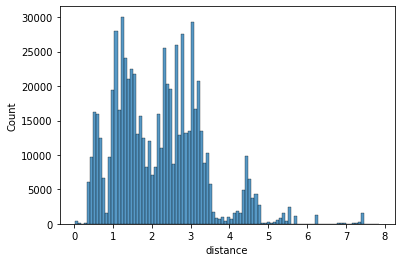

In [600]:
sns.histplot(data=df, x='distance', bins=100)
print('Distance: \n33%-квантиль ={} \n66%-квантиль ={}'.format(df.distance.quantile(q=0.33), df.distance.quantile(q=0.66)))

In [601]:
df['d_type'] = np.select(
    [
        np.round(df['distance'], 1).between(0, 2, inclusive = True),
        np.round(df['distance'], 1).between(2, 3.8, inclusive = True)
    ],
    [
        'Short', 'Medium'
    ],
    default='Long'    
)

#### Time

In [602]:
df['time_struct']=[gmtime(i/1000.0) for i in df.time_stamp]



In [603]:
df['year'] = [i.tm_year for i in df['time_struct']]
df['month'] = [i.tm_mon for i in df['time_struct']]
df['hour'] = [i.tm_hour for i in df['time_struct']]
df['weekday'] = [i.tm_wday for i in df['time_struct']]

In [604]:
df['date'] = pd.to_datetime(df['time_stamp'], unit='ms').dt.date

In [605]:
df.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,cab_type_id,source_id,source_latitude,source_longtitude,destination_id,destination_latitude,destination_longtitude,route_id,route_name,universal_tariff_name,d_type,time_struct,year,month,hour,weekday,date
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared,0,6,42.363789,-71.058442,0,42.36628,-71.060912,33,Haymarket Square-North Station,Shared Ride,Short,"(2018, 12, 16, 9, 30, 7, 6, 350, 0)",2018,12,9,6,2018-12-16
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux,0,6,42.363789,-71.058442,0,42.36628,-71.060912,33,Haymarket Square-North Station,Unknown,Short,"(2018, 11, 27, 2, 0, 23, 1, 331, 0)",2018,11,2,1,2018-11-27
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft,0,6,42.363789,-71.058442,0,42.36628,-71.060912,33,Haymarket Square-North Station,Econom,Short,"(2018, 11, 28, 1, 0, 22, 2, 332, 0)",2018,11,1,2,2018-11-28
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL,0,6,42.363789,-71.058442,0,42.36628,-71.060912,33,Haymarket Square-North Station,SUV Business,Short,"(2018, 11, 30, 4, 53, 2, 4, 334, 0)",2018,11,4,4,2018-11-30
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL,0,6,42.363789,-71.058442,0,42.36628,-71.060912,33,Haymarket Square-North Station,Minivan,Short,"(2018, 11, 29, 3, 49, 20, 3, 333, 0)",2018,11,3,3,2018-11-29


Данные за ноябрь-декабрь 2018 года.

#### Price

In [606]:
df['estimated_price_per_km'] = df.price/df.distance #предполагаемая цена до поездки за км
df['final_price'] = df.price*df.surge_multiplier #итоговая цена
df['final_price_per_km'] = df.final_price/df.distance

Distance: 
33%-квантиль =5.6 
66%-квантиль =10.0


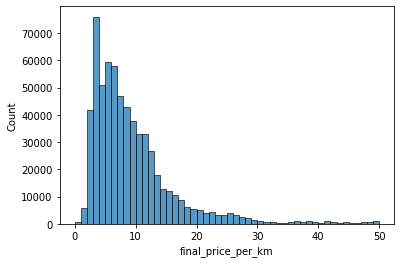

In [607]:
sns.histplot(data=df, x='final_price_per_km', bins=50, binrange=[0, 50])
print('Distance: \n33%-квантиль ={} \n66%-квантиль ={}'.format(df.final_price_per_km.quantile(q=0.33), df.final_price_per_km.quantile(q=0.66)))

In [608]:
df['final_price_per_km'].sort_values(ascending = False).head(30)

161437    1375.000000
608065    1375.000000
612924    1375.000000
159031    1375.000000
153191    1375.000000
608779    1375.000000
159165    1375.000000
613755    1375.000000
156228    1375.000000
611596    1375.000000
254027     916.666667
257501     916.666667
258998     916.666667
523014     916.666667
251515     916.666667
254562     916.666667
252573     916.666667
520142     916.666667
523087     916.666667
257094     916.666667
252095     916.666667
251315     916.666667
255089     916.666667
254796     916.666667
253816     916.666667
253123     916.666667
250864     916.666667
529055     900.000000
522073     900.000000
520606     900.000000
Name: final_price_per_km, dtype: float64

In [609]:
pd.to_datetime(1544952607890, unit='ns')

Timestamp('1970-01-01 00:25:44.952607890')

In [610]:
import time
time.localtime(1544952607890)

time.struct_time(tm_year=50927, tm_mon=8, tm_mday=8, tm_hour=1, tm_min=11, tm_sec=30, tm_wday=4, tm_yday=220, tm_isdst=0)

Есть некоторые поездки > 50 долларов за км  
Я бы разделила так: до 5 долларов - дешевые, от 5 до 10 -нормальная цена, от 10 до 20 - дорогие, > 30 очень дорогие

In [611]:
df['p_type'] = np.select(
    [
        np.round(df['final_price_per_km'], 1).between(0, 5, inclusive = True),
        np.round(df['final_price_per_km'], 1).between(5.1, 10, inclusive = True),
        np.round(df['final_price_per_km'], 1).between(10.1, 30, inclusive = True)
    ],
    [
        'Cheap', 'Medium', 'Expensive'
    ],
    default='Very Expensive'    
)

##### Surge_multiplier
Почти за каждую поездку = 1, т.е. цена не менялась 

In [612]:
print('Процент поездок с возросшей ценой:',round(df[df.surge_multiplier>1.0].shape[0]/df.shape[0]*100, 2))

Процент поездок с возросшей ценой: 3.03


In [613]:
df['price_increase']=[i!=1 for i in df.surge_multiplier]

##### Date and Hour

In [ ]:
def get_date_and_hour_ns(val):
    timestamp = pd.to_datetime(val, unit='ms')
    return str(timestamp.date()) + ':' + str(timestamp.hour)


df['date_and_hour'] = df['time_stamp'].apply(get_date_and_hour_ns)

### Сохраним получившийся датасет

In [ ]:
df.head()

In [ ]:
df.to_csv("data/processed_cab_rides.csv")

#### Данные для визуализации в Kepler

Для построения самих путей

In [ ]:
uber_df = df[df['cab_type'] == 'Uber']
lyft_df = df[df['cab_type'] == 'Lyft']

route_stats = df.groupby(['source', 'destination'], as_index=False).agg({
    'distance':'count',
    'final_price_per_km':'mean'
})

place_df.columns = ['source', 'source_id', 'source_latitude', 'source_longtitude']
route_stats = route_stats.join(place_df.set_index('source'), on ='source', how = 'left')

place_df.columns = ['destination', 'destination_id', 'destination_latitude', 'destination_longtitude']
route_stats = route_stats.join(place_df.set_index('destination'), on ='destination', how = 'left')

route_stats.to_csv('data/route_stats.csv')

Для простроения точек

In [ ]:
source_stats = df.groupby(['source', 'source_latitude', 'source_longtitude'], as_index=False).agg({
    'distance':'count',
    'final_price_per_km':'mean'
})

source_stats_uber = uber_df.groupby(['source', 'source_latitude', 'source_longtitude'], as_index=False).agg({
    'distance':'count',
    'final_price_per_km':'mean'
})

source_stats_lyft = lyft_df.groupby(['source', 'source_latitude', 'source_longtitude'], as_index=False).agg({
    'distance':'count',
    'final_price_per_km':'mean'
})

source_stats.to_csv('data/source_stats.csv')
source_stats_uber.to_csv('data/source_stats_uber.csv')
source_stats_lyft.to_csv('data/source_stats_lyft.csv')

For TableAU Butterfly chart

In [ ]:
uber__ = df[df['cab_type'] == 'Uber']
lyft__ = df[df['cab_type'] == 'Lyft']

by_tariff = uber__.groupby(['cab_type', 'universal_tariff_name'], as_index = False).agg({
    'final_price_per_km':['mean', 'median'],
    'final_price':['mean', 'median']
})
by_tariff.columns = ['cab_type', 'universal_tariff_name', 'price_per_km_mean', 'price_per_km_median', 'final_price_mean', 'final_price_median']

by_tariff = by_tariff[by_tariff['universal_tariff_name'] != 'Unknown']
by_tariff = by_tariff[['universal_tariff_name', 'price_per_km_median', 'price_per_km_mean']]
by_tariff.columns = ['universal_tariff_name', 'price_per_km_median_uber', 'price_per_km_mean_uber']

lyft_by_tariff = lyft__.groupby(['cab_type', 'universal_tariff_name'], as_index = False).agg({
    'final_price_per_km':['mean', 'median']
})

lyft_by_tariff = lyft_by_tariff[lyft_by_tariff['universal_tariff_name'] != 'Unknown']
lyft_by_tariff.columns = ['cab_type', 'universal_tariff_name', 'price_per_km_mean_lyft', 'price_per_km_median_lyft']
lyft_by_tariff = lyft_by_tariff[['universal_tariff_name', 'price_per_km_mean_lyft', 'price_per_km_median_lyft']]


# lyft_by_tariff
by_tariff = by_tariff.join(lyft_by_tariff.set_index('universal_tariff_name'), on = 'universal_tariff_name', how = 'left')

In [ ]:
by_tariff

In [ ]:
by_tariff.to_csv('data/by_tariff_comparison.csv')

## Анализ данных
Важные колонки - cab_type, distance, destination, source, name, hour, weekday, final_price(итоговая цена), final_price_per_km (цена за км), d_type (короткая/средняя/большая дистанция), p_type (дешево/средне/дорого/очень дорого), price_increase (выросла цена или нет), route_name (маршрут, всего их 72)

### Тарифы

In [ ]:
df.groupby(['cab_type', 'name']).agg({'name':'count', 
                                     'distance':['min','mean', 'max', 'std'],
                                     'final_price_per_km': ['min','mean', 'max', 'std'],
                                     'price_increase': lambda x: round(x.mean()*100),
                                     'p_type':[lambda x: round(x[x=='Cheap'].count()), 
                                               lambda x: round(x[x=='Medium'].count()),
                                               lambda x: round(x[x=='Expensive'].count()), 
                                               lambda x: round(x[x=='Very Expensive'].count())],
                                     'd_type':[lambda x: round(x[x=='Short'].count()), 
                                               lambda x: round(x[x=='Medium'].count()),
                                               lambda x: round(x[x=='Long'].count())]}
                                    )

1. Нет данных о цене по тарифу Такси  
2. Соответствия тарифов по средней цене и распределению(примерно):  
* Lux Black XL = Black SUV 19-20usd  
* Lux Black = Black 12-13 usd    
* Lux, Lyft XL = Uber XL 9-10 usd  
* Lyft = UberX, UberPool, WAV  5-6 usd  
* Shared 3 usd

3. <strong><span style="color:purple">В убере никогда не повышают итоговую цену, в то время как в Лифт это случается у каждого 13-го клиента</span></strong>
4. Распределение по distance одинаковое для всех тарифов

In [ ]:
df[df['cab_type'] == 'Lyft'].groupby('name')['distance'].mean()

### Длина маршрута

In [ ]:
df.groupby(['cab_type', 'd_type']).agg({'d_type':'count',
                                     'final_price_per_km': ['min','mean', 'max', 'std'],
                                     'price_increase': lambda x: round(x.mean()*100)})

### Присутствие кампаний в разных гео

In [ ]:
df.groupby(['cab_type', 'route_name']).agg({'route_name':'count',
                                     'final_price_per_km': ['mean', 'std']})

Видно, что некоторые маршруты дороже, посмотрим какие:

In [ ]:
route_price =  pd.pivot_table(df.groupby(['source','destination']).agg({'final_price_per_km': 'mean'}),
                              values='final_price_per_km',
                              index=['source'],
                              columns=['destination'])
sns.heatmap(route_price, annot=True)

Теперь посмотрим куда ездят такси разных компаний:

In [ ]:
uber = df[df.cab_type_id==1].copy()
lyft = df[df.cab_type_id==0].copy()

In [ ]:
route_count_uber =  pd.pivot_table(uber.groupby(['source','destination']).agg({'name': lambda x: round(x.count()*100/uber.shape[0],3)}),
                              values='name',
                              index=['source'],
                              columns=['destination'])
route_count_lyft =  pd.pivot_table(lyft.groupby(['source','destination']).agg({'name': lambda x: round(x.count()*100/lyft.shape[0],3)}),
                              values='name',
                              index=['source'],
                              columns=['destination'])
plt.figure(figsize=(20,4))
ax =plt.subplot(121)
plt.title('Uber')
sns.heatmap(route_count_uber,annot=True, vmin = 1.3, vmax=1.5)
ax =plt.subplot(122)
plt.title('Lyft')
sns.heatmap(route_count_lyft, annot=True,vmin = 1.3, vmax=1.5)

Посчитаем отношение количества поездок в те или иные районы в Убер и Лифт

In [ ]:
lyft_ = pd.DataFrame(df[df['cab_type'] == 'Lyft'].groupby('route_name')['distance'].count())
uber_ = pd.DataFrame(df[df['cab_type'] == 'Uber'].groupby('route_name')['distance'].count())
uber_ = round(uber_ / uber_.sum() * 100, 2)
lyft_ = round(lyft_ / lyft_.sum() * 100, 2)
round(uber_ / lyft_, 2).sort_values(by = 'distance', ascending = False)

На основании данных из таблицы, можно сделать вывод что на всех представленных маршрутах виден полный партитет кампаний по их относительному уровню популярности в них
Убер везде в среднем заказывают на 25% больше, что соответствует отношению всех поездок этих кампаний

### Время поездки

In [ ]:
time_uber = pd.pivot_table(uber.groupby([ 'weekday', 'hour']).agg({'name':'count',
                                     'final_price_per_km':'mean'}),
            values=['name', 'final_price_per_km'],
            index=['weekday'],
            columns=['hour'])

In [ ]:
plt.figure(figsize=(20,4))
ax =plt.subplot(121)
plt.title('Uber count')
sns.heatmap(time_uber.name)
ax =plt.subplot(122)
plt.title('Uber price')
sns.heatmap(time_uber.final_price_per_km,vmin = 8, vmax=13)

In [ ]:
time_lyft = pd.pivot_table(lyft.groupby([ 'weekday', 'hour']).agg({'name':'count',
                                     'final_price_per_km':'mean'}),
            values=['name', 'final_price_per_km'],
            index=['weekday'],
            columns=['hour'])

In [ ]:
plt.figure(figsize=(20,4))
ax =plt.subplot(121)
plt.title('Lyft count')
sns.heatmap(time_lyft.name)
ax =plt.subplot(122)
plt.title('Lyft price')
sns.heatmap(time_lyft.final_price_per_km, vmin = 8, vmax=13)

Получается, что у убера в целом дешевле, но неравномернее распределение по времени  
Еще непонятно, почему нет данных за ночи всех сред

#### Прямое сравнение присутствия кампаний по времени дня

Посчитаем отношение поездок в разрезе на время дня для обеих кампаний и визуализируем динамику изменения этого отношения на протяжении дня

In [ ]:
a = pd.DataFrame(df.groupby(['cab_type','hour'])['distance'].count().unstack()).transpose()
a['hour'] = pd.Series(a.index)

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
fig.update_layout(
    title_text='Сравнение количества поездок в течение суток'
)
fig.add_trace(go.Scatter(x=a['hour'], y=a['Uber'],
                    mode='lines',
                    name='Uber'))
fig.add_trace(go.Scatter(x=a['hour'], y=a['Lyft'],
                    mode='lines',
                    name='Lyft'))
fig.show()

Видим, что в течение суток динамика спроса сервисов равна

#### Прямое сравнение ценообразования кампаний по времени дня

Посмотрим теперь на динамику ценообразования в течение суток

In [ ]:
a = pd.DataFrame(df.groupby(['cab_type','hour'])['final_price_per_km'].mean().unstack()).transpose()
a['hour'] = pd.Series(a.index)

In [ ]:
fig = go.Figure()
fig.update_layout(
    title_text='Сравнение цены поездок в течение суток'
)
fig.add_trace(go.Scatter(x=a['hour'], y=a['Uber'],
                    mode='lines',
                    name='Uber'))
fig.add_trace(go.Scatter(x=a['hour'], y=a['Lyft'],
                    mode='lines',
                    name='Lyft'))
fig.show()

<strong><span style="color:purple">Убер дешевле, чем Лифт на протяжении всего дня</span></strong>

<strong><span style="color:purple">У Убера бОльшая волатильность, из-за чего цена за минуту иногда достигает цену за минуту в Лифт</span></strong>

## Идеи по дашборду:
1. Разделить экран на две половины: с одной Убер, с другой - Лифт  
2. Возможность выбора тарифа, промежутка цены и дистанции, места отправления и посадки, час, день недели  - выпадение из списка со множественным выбором  
3. Возможность выбора промежутка времени - слайдер  
4. Bar plot со значением цены от тарифа 
5. heatmap с процентом поездок от маршрута и heatmap со средней ценой от маршрута
6. Временной ряд количества поездок, разными цветами - разные тарифы
7. Временной ряд цены поездок за км, разными цветами - разные тарифы

## Погода

Препроцессинг для джоина в табло

In [ ]:
weather_df = pd.read_csv('data/weather.csv')

In [ ]:
def get_date_and_hour(val):
    timestamp = pd.to_datetime(val, unit='s')
    return str(timestamp.date()) + ':' + str(timestamp.hour)

weather_df['date_and_hour'] = weather_df['time_stamp'].apply(get_date_and_hour)

In [ ]:
def rain_classificator(val):
    if math.isnan(val):
        return 'No rain'
    if val < 0.10:
        return 'light rain'
    if val < 0.30:
        return 'moderate'
    return 'heavy'

weather_df['rain_rating'] = weather_df['rain'].apply(rain_classificator)

In [ ]:
weather_df['rain_rating'].value_counts()

In [ ]:
weather_df.to_csv("data/processed_weather.csv")